In [1]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd
import pickle

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('../../files/xsec.json') as f:
    xs = json.load(f)

with open('../../files/pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


## Get significance from combine scan

In [2]:
#Open one file and extract the thresholds and significance
def open_file_and_extract(file_path):
    
    thresholds_temp = []
    thresholds = []
    significance = []
    
    with open(file_path) as f:
        lines = f.read().splitlines()
        
    for x in lines:
        
        if x.endswith('>>>') and not x.startswith('>>>'):
            thresholds_temp.append([float(y[5:]) for y in x[:-4].split(';')])
            
        if x.startswith('Significance:'):            
            significance.append(float(x[14:]))
            thresholds.append(thresholds_temp[-1])
            
    return thresholds, significance
    
    print("Thresholds:", thresholds)
    print("Significance: ", significance)
    
def scan_logs_out(log_dir):
    
    ddb_thres = []
    ddc_thres = []
    all_sign = []
    
    #Loop over the files
    for file in os.listdir(log_dir):
        
        filename = os.fsdecode(file)
        if filename.endswith(".out"):
            local_thres, local_sign = open_file_and_extract(os.path.join(log_dir,filename))
            
            if len(local_sign) > 0:
                    ddb_thres += [x[0] for x in local_thres]
                    ddc_thres += [x[1] for x in local_thres]
                    all_sign += local_sign
#             elif len(local_sign) < 10:
#                 print("local thres:", local_thres)
#                 print("Local sign: ", local_sign)
                
    
    return np.asarray(ddb_thres), np.asarray(ddc_thres), np.asarray(all_sign)
            
ddb, ddc, sign = scan_logs_out("logs/")

(0.02, 1.0)

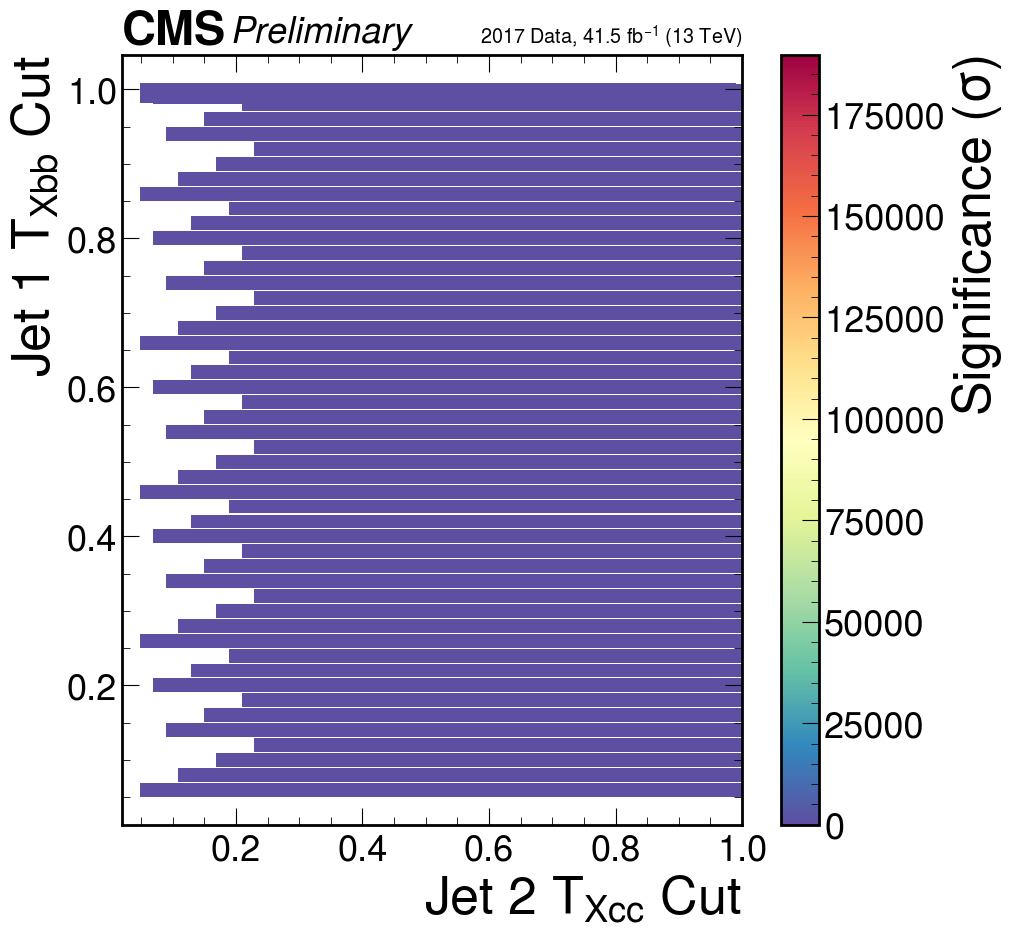

In [3]:
fig, ax = plt.subplots()
im = ax.scatter(ddc, ddb, c=sign, s=100, marker='s', cmap='Spectral_r',linewidths=0)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'Significance ($\sigma$)')

hep.cms.text("Preliminary")
hep.cms.lumitext(r"2017 Data, 41.5 $fb^{-1}$ (13 TeV)", fontsize=15)

plt.xlabel(r"Jet 2 $T_{Xcc}$ Cut")
plt.ylabel(r"Jet 1 $T_{Xbb}$ Cut")
plt.xlim([0.02,1])
#plt.xscale('log')

In [20]:
d = {'Jet 1 b': ddb, 'Jet 2 c': ddc, 'significance':sign}
df = pd.DataFrame(data=d)

In [25]:
df[(df['significance'] > 2)]

,Jet 1 b,Jet 2 c,significance
4812,0.99816,0.96,2.21455
4845,0.99837,0.96,2.15733
4974,0.99918,0.58,189737.00000
5016,0.99857,0.96,2.06164
5039,0.99939,0.26,134164.00000


In [32]:
df[(df['significance'] > 0.75) & (df['significance'] < 2)]

,Jet 1 b,Jet 2 c,significance
4171,0.99469,0.84,0.764455
4204,0.99490,0.84,0.761576
4251,0.99510,0.84,0.769869
4336,0.99551,0.80,0.763097
4799,0.99776,0.58,0.776405
4800,0.99776,0.60,0.766652
4802,0.99776,0.64,0.750955
4855,0.99796,0.58,0.773124
4856,0.99796,0.60,0.763845
4891,0.99816,0.56,0.762247


In [5]:
#Define the working points (for 2017 only)
Xbb_points = [0.9105, 0.9714, 0.9870]
Xcc_points = [0.9347, 0.9765, 0.9909]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


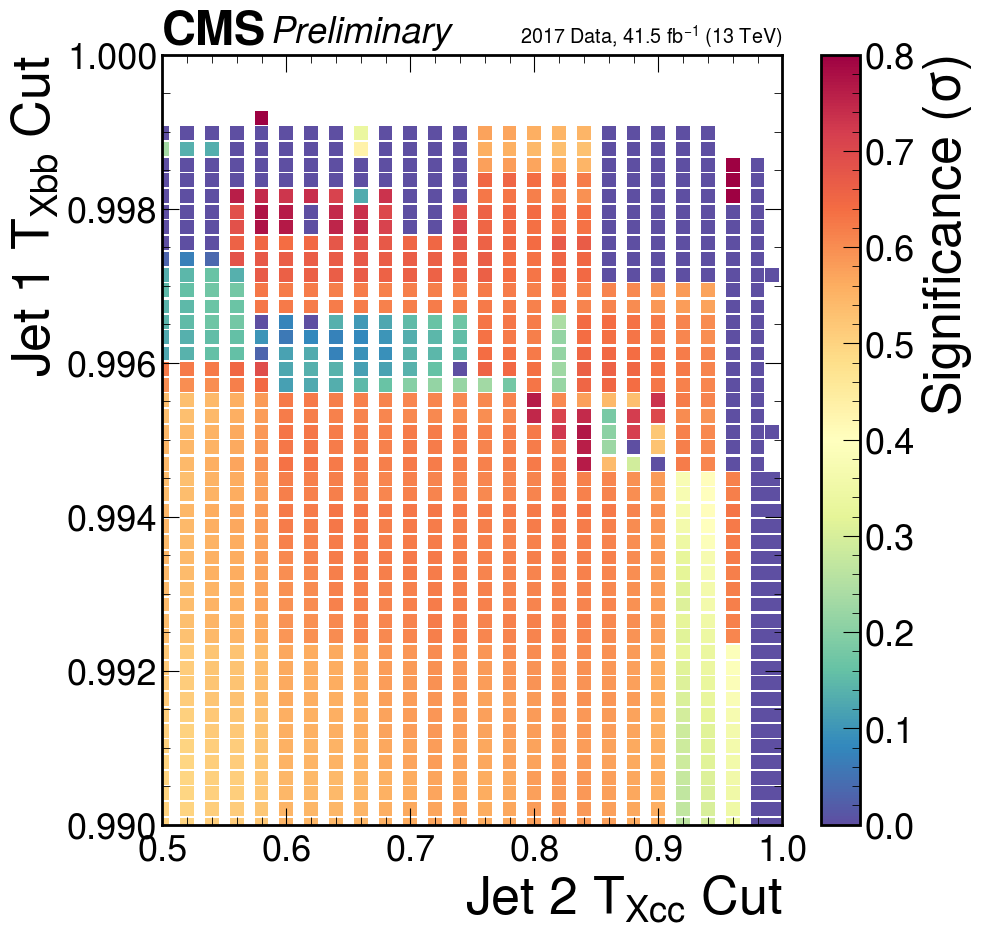

In [18]:
fig, ax = plt.subplots()
im = ax.scatter(ddc, ddb, c=sign, s=100, marker='s', cmap='Spectral_r',linewidths=0, vmin=0., vmax=0.8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'Significance ($\sigma$)')

#Plot the working points
# legend_count = 0

# for Xbb in Xbb_points:
#     for Xcc in Xcc_points:
#         if legend_count == 0:
#             plt.scatter(Xcc, Xbb, s=600, marker='*',
#                         color ='firebrick', label = r"Working points")
#         else:
#             plt.scatter(Xcc, Xbb, s=600, marker='*',
#                         color ='firebrick')
#         legend_count += 1

hep.cms.text("Preliminary")
hep.cms.lumitext(r"2017 Data, 41.5 $fb^{-1}$ (13 TeV)", fontsize=15)

plt.xlabel(r"Jet 2 $T_{Xcc}$ Cut")
plt.ylabel(r"Jet 1 $T_{Xbb}$ Cut")
plt.xlim([0.5,1])
plt.ylim(0.99,1)
plt.legend(loc='best')
#plt.xscale('log')